In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import warnings
import time

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv(r"C:\MIDS\ADS_505_Applied_Data_Science_for_Business\ADS-505_Final_Project_Team_4\data\german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Feature Creation

In [3]:
# Create categorical feature for age
interval = (18, 25, 35, 60, 120)
# (18, 25) represents the interval for "Students" (ages 18 to 25).
# (25, 35) represents the interval for "Young" adults (ages 26 to 35).
# (35, 60) represents the interval for "Adults" (ages 36 to 60).
# (60, 120) represents the interval for "Seniors" (ages 61 to 120).
cats = ['Student', 'Young Adult', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

### Summary Statistics

In [4]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the dataset and store the summary
summary = analyze_data(df)
summary

Dataset Shape: (1000, 11)


,Name,dtypes,Missing,Uniques,First Value,Entropy,Skewness,Kurtosis,Min,Mean,Median,Max,Std,Outliers
0,Age,int64,0,53,67,5.27,1.02,0.59,19.0,35.546,33.0,75.0,11.375469,23.0
1,Sex,object,0,2,male,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Job,int64,0,4,2,1.41,-0.37,0.49,0.0,1.904,2.0,3.0,0.653614,370.0
3,Housing,object,0,3,own,1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Saving accounts,object,183,4,NaN,1.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Checking account,object,394,3,little,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Credit amount,int64,0,921,1169,9.80,1.95,4.27,250.0,3271.258,2319.5,18424.0,2822.736876,72.0
7,Duration,int64,0,33,6,3.76,1.09,0.91,4.0,20.903,18.0,72.0,12.058814,70.0
8,Purpose,object,0,8,radio/TV,2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Risk,object,0,2,good,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Target Variable Distribution 

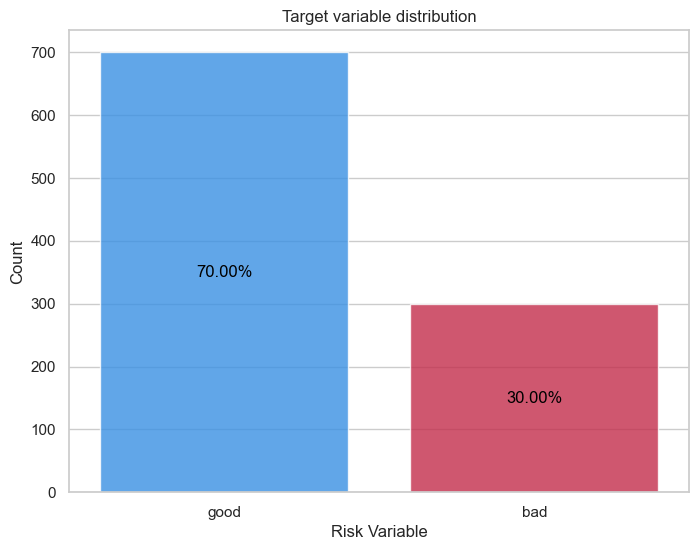

In [5]:
# Calculate the counts for 'good' and 'bad' credit
counts = df['Risk'].value_counts()

# Calculate the percentages
total_count = counts.sum()
percentages = (counts / total_count) * 100

# Create a bar chart with percentages in the center of each bar using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=counts.index, y=counts.values, palette=['dodgerblue', 'crimson'], alpha=0.8)
plt.xlabel('Risk Variable')
plt.ylabel('Count')
plt.title('Target variable distribution')

# Add percentages at the center of each bar
for bar, percentage in zip(ax.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.2f}%', 
             ha='center', va='center', fontsize=12, color='black')

plt.show()

#### Distribution of Numerical Features vs Target

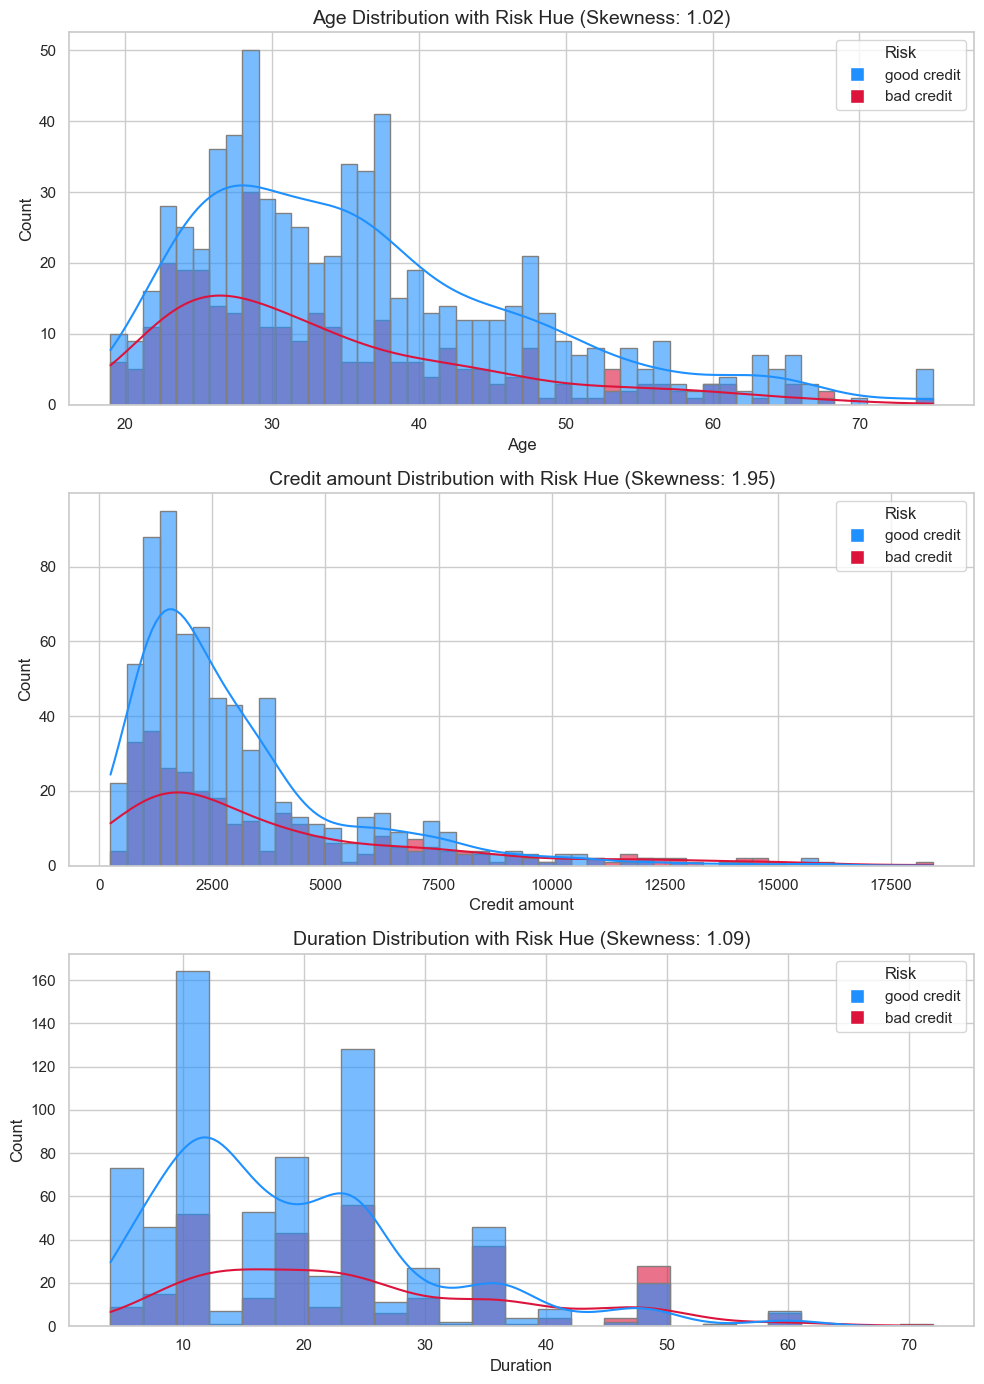

In [6]:
# Create a 3x1 grid of histograms with different bin counts
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Columns to plot and their corresponding bin counts
columns_to_plot = ['Age', 'Credit amount', 'Duration']
bin_counts = [50, 50, 25]  # Adjust the bin counts as needed

# Loop through columns and create histograms with specified bin counts
for i, (column, bins) in enumerate(zip(columns_to_plot, bin_counts)):
    ax = axes[i]
    
    # Calculate skewness
    skewness = df[column].skew()
    
    sns.histplot(data=df, x=column, hue='Risk', alpha=0.6, element='bars', bins=bins, 
                 palette={'good': 'dodgerblue', 'bad': 'crimson'}, edgecolor='grey', kde=True, legend=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Add skewness to the title
    ax.set_title(f'{column} Distribution with Risk Hue (Skewness: {skewness:.2f})', fontsize=14)
    sns.set(style="whitegrid")
    legend_labels = ['good credit', 'bad credit']
    legend_colors = ['dodgerblue', 'crimson']
    legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles=legend_handles, title='Risk')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

#### Distribution of Categorical Features vs Target

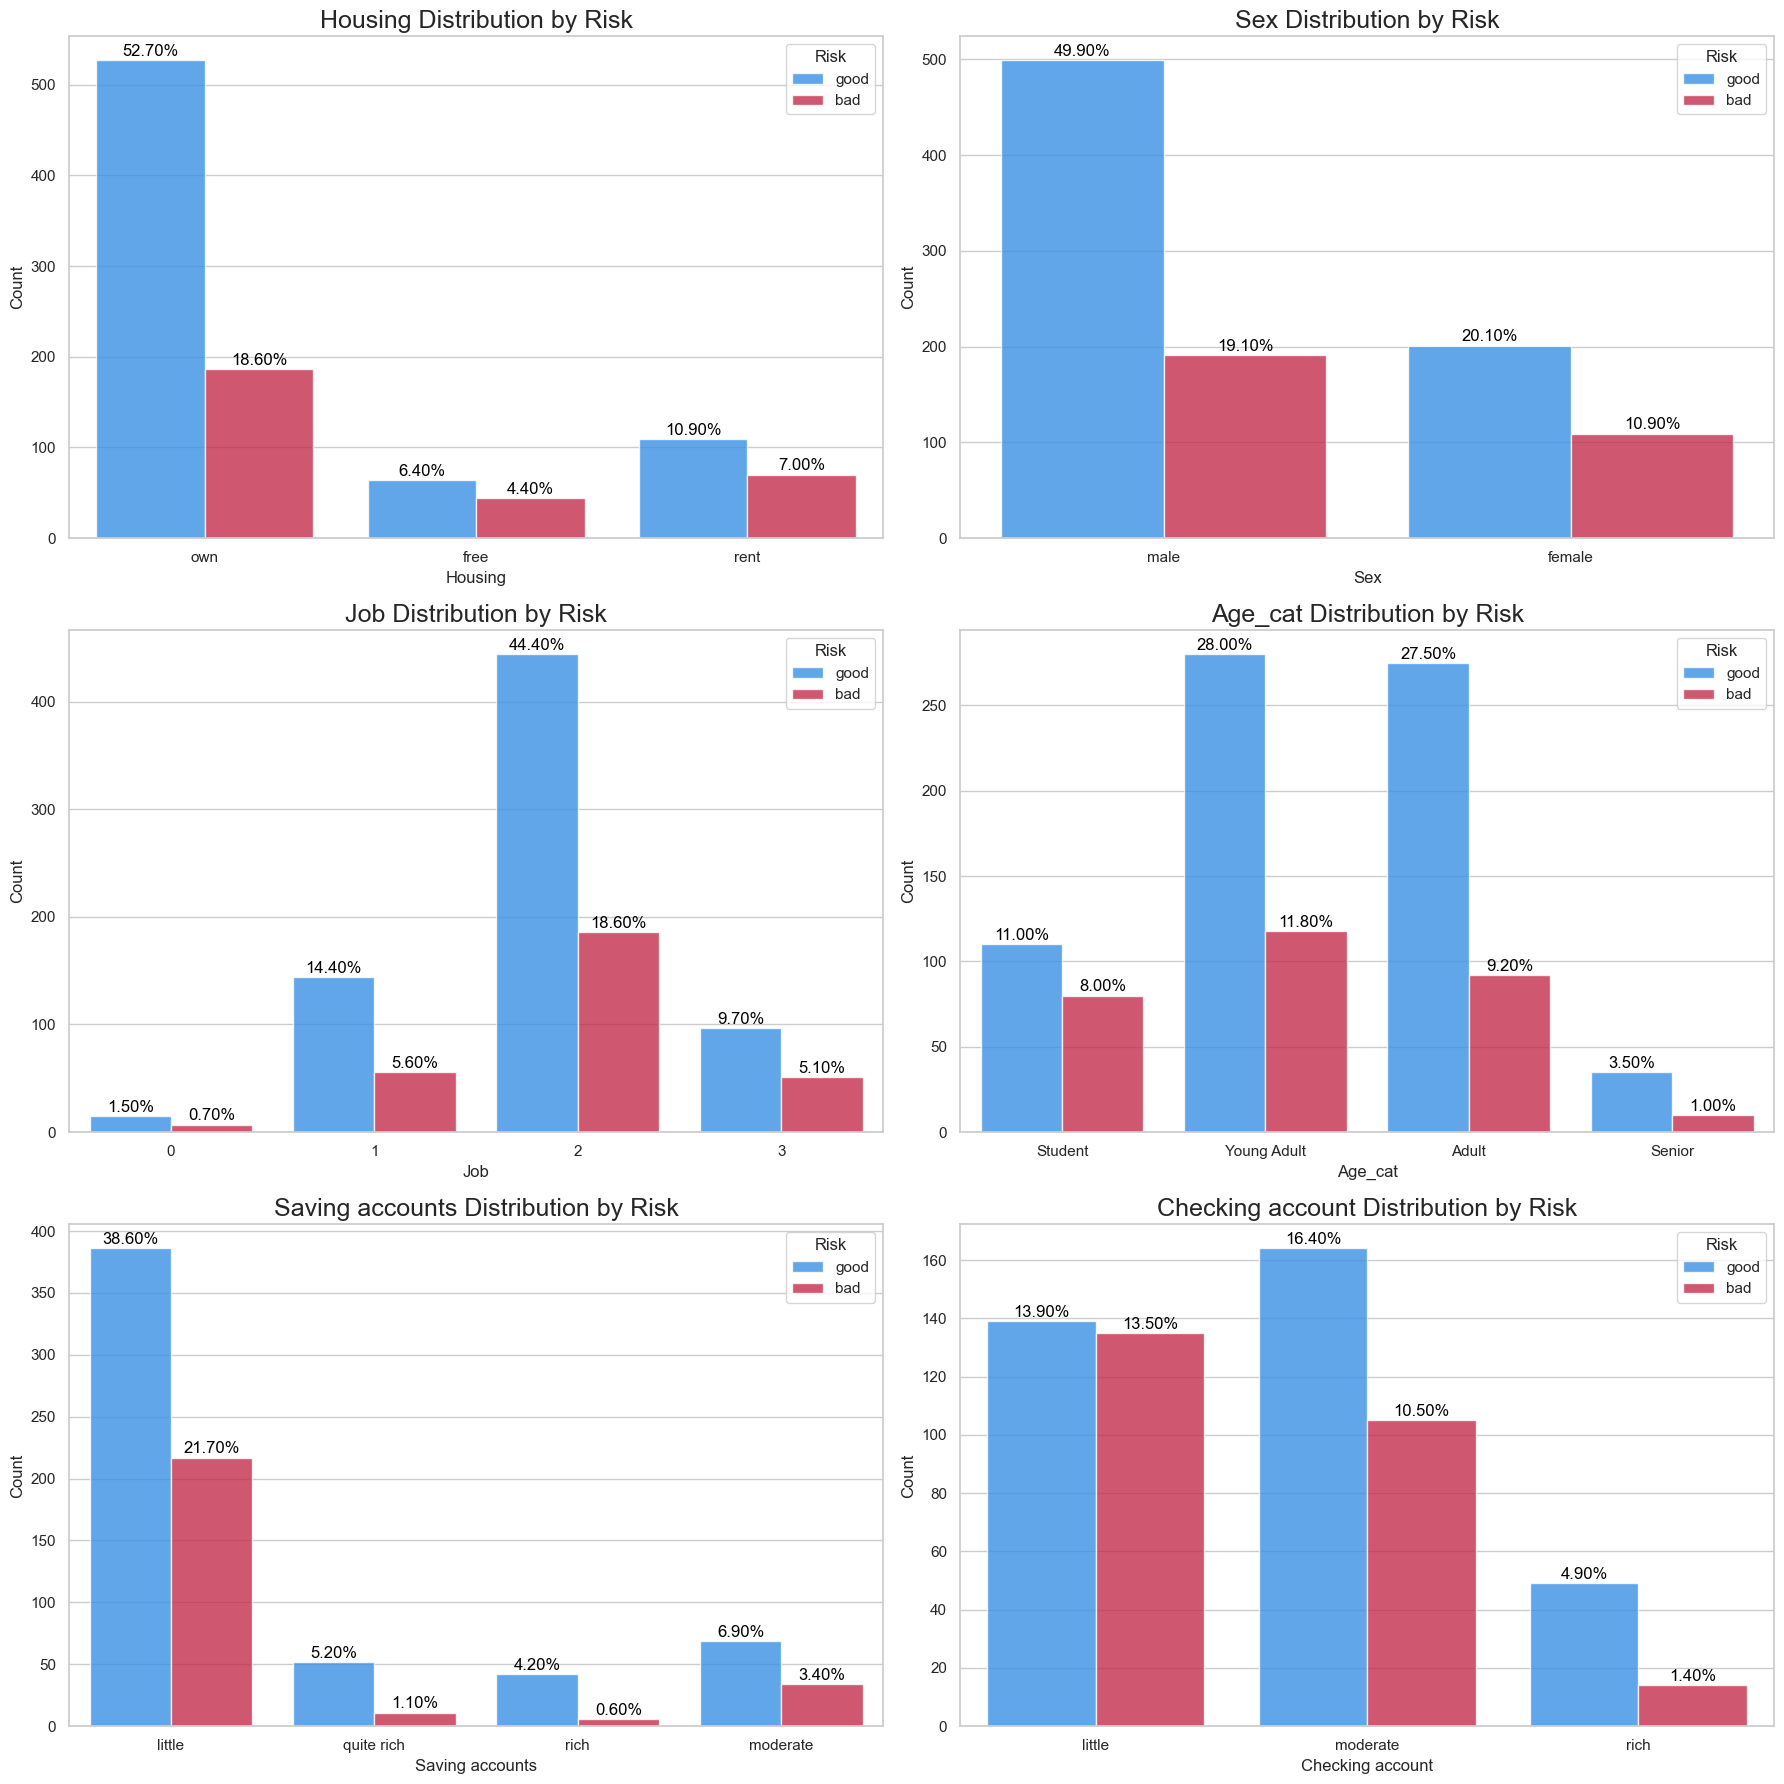

In [7]:
# Create a 3x2 grid of count plots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
# Columns to plot
columns_to_plot = ['Housing', 'Sex', 'Job', 'Age_cat', 'Saving accounts', 'Checking account']

# Loop through columns and create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = sns.countplot(data=df, x=column, hue='Risk', alpha=0.8, palette={'good': 'dodgerblue', 'bad': 'crimson'}, ax=axes[row, col])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Distribution by Risk', fontsize=18)  
    
    # Add percentages on top of the bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height / len(df) * 100:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', fontsize=12, color='black')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend(title='Risk', loc='upper right')
plt.show()

### Data Preprocessing & Feature Engineering

In [8]:
categorical_columns = ['Housing', 'Sex', 'Job', 'Age_cat', 'Saving accounts', 'Checking account', 'Purpose']
df_encoded = pd.get_dummies(df, columns=categorical_columns)
print(df_encoded.columns)

Index(['Age', 'Credit amount', 'Duration', 'Risk', 'Housing_free',
       'Housing_own', 'Housing_rent', 'Sex_female', 'Sex_male', 'Job_0',
       'Job_1', 'Job_2', 'Job_3', 'Age_cat_Student', 'Age_cat_Young Adult',
       'Age_cat_Adult', 'Age_cat_Senior', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others'],
      dtype='object')


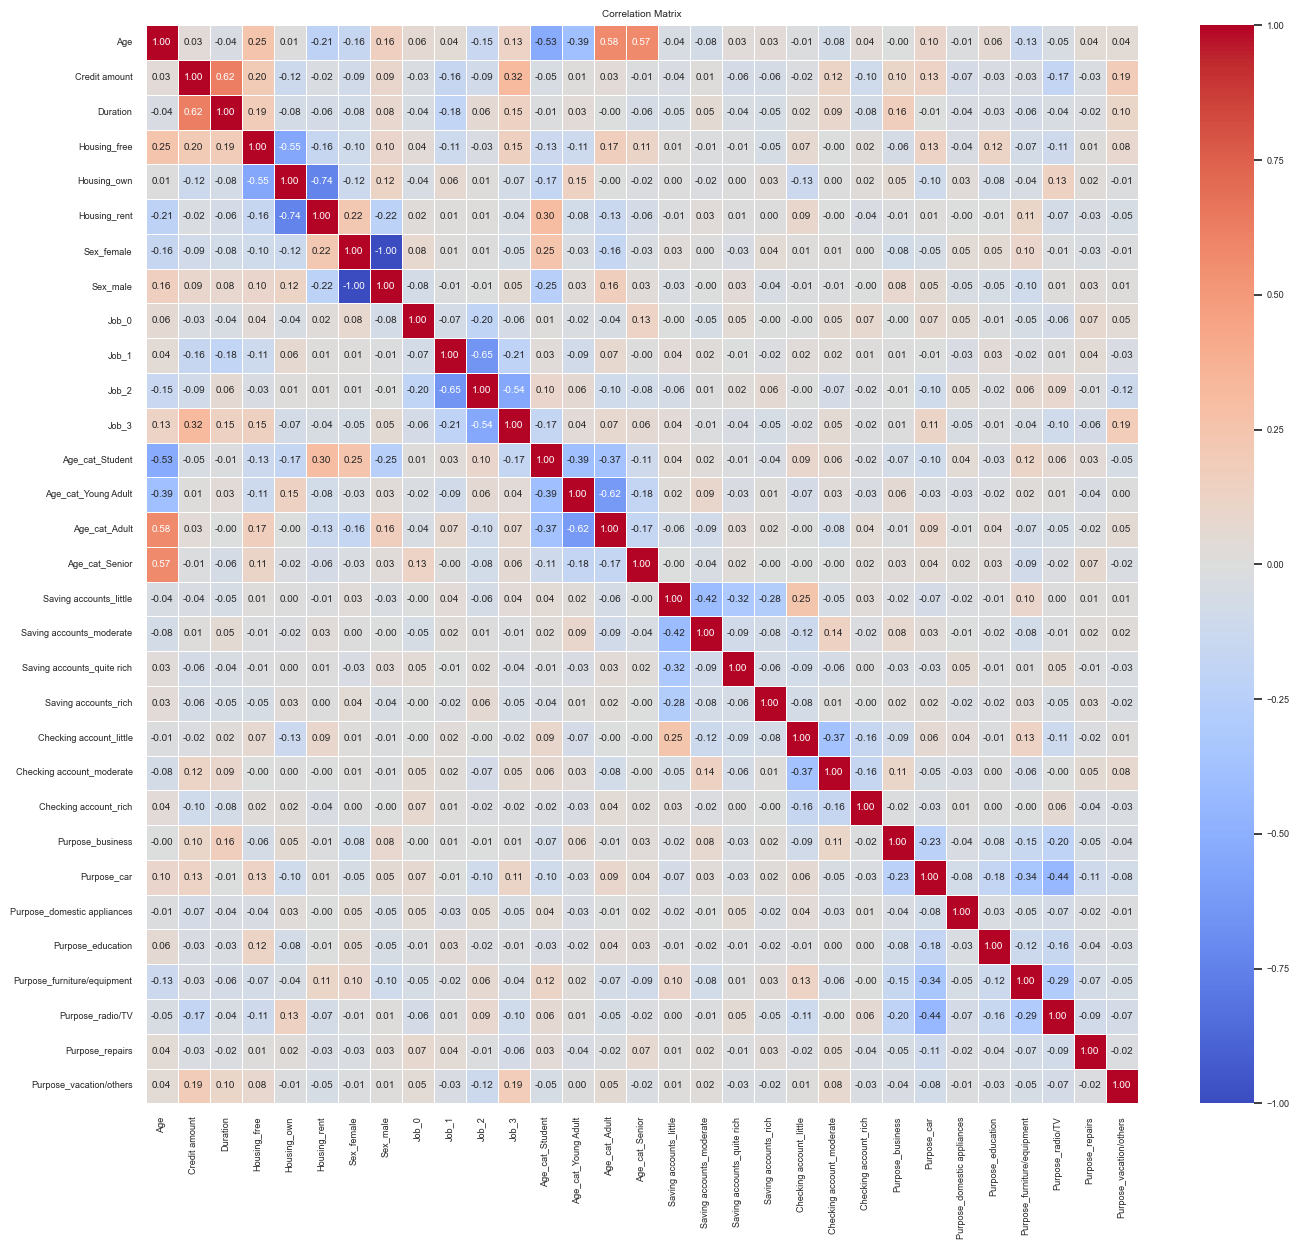

In [9]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Set up the figure and axis for the heatmap
plt.figure(figsize=(16, 14))
sns.set(font_scale=0.6)  # Adjust the font scale if needed

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Machine Learning (Work in progress...)

In [ ]:
def preprocess_data(data, missing_method=None, outlier_method=None, knn_neighbors=5, lof_neighbors=20, lof_contamination=0.1, skewness_transform=None):
    """
    Preprocesses data by handling missing values, outliers, and skewness.

    Parameters:
        data (DataFrame): Input data with features and target.
        missing_method (str): Method for handling missing values ('drop', 'knn', or 'regression').
        outlier_method (str): Method for handling outliers ('iqr' or 'lof').
        knn_neighbors (int): Number of neighbors for KNN imputation.
        lof_neighbors (int): Number of neighbors for Local Outlier Factor.
        lof_contamination (float): Proportion of outliers expected in LOF.
        skewness_transform (str): Skewness transformation method ('log', 'boxcox', 'sqrt', 'cbrt').

    Returns:
        preprocessed_data (DataFrame): Preprocessed data after handling missing values, outliers, and skewness.
    """
    preprocessed_data = data.copy()
    
    # Handling missing values using KNN imputer
    if missing_method == 'drop':
        preprocessed_data.dropna(inplace=True)
    elif missing_method == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        preprocessed_data = pd.DataFrame(imputer.fit_transform(preprocessed_data), columns=data.columns)
    elif missing_method == 'regression':
        for column in preprocessed_data.columns:
            incomplete_rows = preprocessed_data[preprocessed_data[column].isnull()]
            complete_rows = preprocessed_data[~preprocessed_data[column].isnull()]
            X_complete = complete_rows.drop(columns=[column])
            y_complete = complete_rows[column]
            regressor = RandomForestRegressor()  # Use any suitable regression model
            regressor.fit(X_complete, y_complete)
            imputed_values = regressor.predict(incomplete_rows.drop(columns=[column]))
            preprocessed_data.loc[preprocessed_data[column].isnull(), column] = imputed_values
    
    # Handling outliers using LOF
    if outlier_method == 'lof' and missing_method == 'knn':
        lof = LocalOutlierFactor(n_neighbors=lof_neighbors, contamination=lof_contamination)
        outlier_scores = lof.fit_predict(preprocessed_data)
        preprocessed_data = preprocessed_data[outlier_scores == 1]
    
    # Skewness transformation
    if skewness_transform == 'log':
        preprocessed_data = preprocessed_data.apply(lambda x: np.log1p(x))
    elif skewness_transform == 'boxcox':
        from scipy.stats import boxcox
        for column in preprocessed_data.columns:
            preprocessed_data[column] = boxcox(preprocessed_data[column] + 1)[0]
    elif skewness_transform == 'sqrt':
        preprocessed_data = preprocessed_data.apply(lambda x: np.sqrt(x))
    elif skewness_transform == 'cbrt':
        preprocessed_data = preprocessed_data.apply(lambda x: np.cbrt(x))
    return preprocessed_data

# Apply to only the predictor variables
predictor_var = df_encoded.drop(columns=['Risk'])

# Set parameters and process the data
preprocessed_data = preprocess_data(predictor_var, 
                                    missing_method='drop', 
                                    outlier_method=None, 
                                    knn_neighbors=5, 
                                    lof_neighbors=20, 
                                    lof_contamination=0.1, 
                                    skewness_transform='boxcox')

# Add the 'Risk' column back to the preprocessed data
preprocessed_data = preprocessed_data.copy()  # Make a copy of the preprocessed predictor variables
preprocessed_data['Risk'] = df_encoded['Risk']  # Add the 'Risk' column back
preprocessed_data

In [ ]:
# Define a dictionary mapping sampling techniques to their corresponding resampling objects
resampling_methods = {
    'oversample': RandomOverSampler,
    'smote': SMOTE,
    'adasyn': ADASYN,
    'undersample': RandomUnderSampler,
    'resample': resample  
}

def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test, 
                                  scaling_method=None, sampling_technique=None, threshold=0.5):
    """
    Train and evaluate each classification model and evaluate their performancec. 

    Parameters:
        classifier: Classifier instance to train and evaluate.
        X_train: Training data features.
        y_train: Training data target.
        X_test: Testing data features.
        y_test: Testing data target.
        scaling_method (str): Method for scaling the data ('standard', 'minmax', or 'robust').
        sampling_technique (str): Method for applying sampling to handle class imbalance.
        threshold (float): Threshold value for converting probabilities to binary predictions.

    Returns:
        accuracy (float): Accuracy of the classifier.
        precision (float): Precision of the classifier.
        recall (float): Sensitivity/Recall of the classifier.
        specificity (float): Specificity of the classifier.
        roc_auc (float): ROC AUC score of the classifier.
        elapsed_time (float): Time taken for training and evaluation.
        feature_importances (pd.Series or None): Feature importances (if available).
        y_pred_probs (numpy.array): Predicted probabilities for the positive class.
    """
        
    start_time = time.time()

    if sampling_technique in resampling_methods:
        resampler = resampling_methods[sampling_technique](sampling_strategy='auto', random_state=42)
        X_train, y_train = resampler.fit_resample(X_train, y_train)

    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    classifier.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Obtain predicted probabilities for the positive class
    y_pred_probs = classifier.predict_proba(X_test)[:, 1]

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    feature_importances = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        
    return accuracy, precision, recall, specificity, roc_auc, elapsed_time, feature_importances, y_pred_probs

# Declare target variable and predictor variables
X = preprocessed_data.drop(columns=['Risk'])
y = preprocessed_data['Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 250, 500],  # Standard: 100
        'max_depth': [None, 10, 20],      # Standard: None
        'min_samples_split': [2, 5, 10],  # Standard: 2
        'min_samples_leaf': [1, 2, 4],    # Standard: 1
        'max_features': ['auto', 'sqrt', 'log2']  # Standard: 'auto'
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 10, 20],          # Standard: None
        'min_samples_split': [2, 5, 10],      # Standard: 2
        'min_samples_leaf': [1, 2, 4],        # Standard: 1
        'max_features': ['auto', 'sqrt', 'log2']  # Standard: None
    }),
    # This model takes WAY too long to run... which is why it is commented out
    # 'SVM': (SVC(kernel='linear', random_state=42, probability=True), {
    #     'C': [0.1, 1, 10],               # Standard: 1
    #     'gamma': ['scale', 'auto', 0.1, 1],   # Standard: 'scale'
    # }),
    'XGBoost': (XGBClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],  # Standard: 100
        'max_depth': [3, 5, 7],           # Standard: 3
        'learning_rate': [0.01, 0.1, 0.2],  # Standard: 0.3
        'subsample': [0.8, 1.0],          # Standard: 1.0
        'colsample_bytree': [0.8, 1.0],   # Standard: 1.0
        'gamma': [0, 1, 5]                # Standard: 0
    }),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {
        'hidden_layer_sizes': [(50,), (100,), (150,)],  # Standard: (100,)
        'activation': ['relu', 'logistic'],            # Standard: 'relu'
        'alpha': [0.0001, 0.001, 0.01],                 # Standard: 0.0001
        'learning_rate': ['constant', 'adaptive'],      # Standard: 'constant'
    }),
    'Logistic Regression': (LogisticRegression(random_state=42), {
        'C': [0.1, 1, 10],             # Standard: 1
        'penalty': ['l1', 'l2'],       # Standard: 'l2'
        'solver': ['liblinear', 'lbfgs', 'saga']  # Standard: 'lbfgs'
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],       # Standard: 5
        'weights': ['uniform', 'distance'],  # Standard: 'uniform'
        'p': [1, 2]                     # Standard: 2
    }),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],  # Standard: 50
        'learning_rate': [0.1, 0.5, 1.0],  # Standard: 1.0
    }),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {
        'n_estimators': [10, 20, 30],   # Standard: 10
        'max_samples': [0.5, 1.0],      # Standard: 1.0
        'max_features': [0.5, 1.0],     # Standard: 1.0
    }),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

# To enable scaling, pass scaling_method='standard' or scaling_method='minmax'
# To disable scaling, pass scaling_method=None
# To use sampling, pass sampling_technique='oversample', 'smote', 'adasyn', or 'undersample'
# To use both scaling and sampling, pass both scaling_method and sampling_technique
# Train and evaluate each classifier with the desired processing method

threshold = 0.5  # Set the desired threshold value (can be any value between 0 and 1)
scaling_method = 'standard'
sampling_technique = 'adasyn'

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

for name, (classifier, param_grid) in tqdm(classifiers.items(), desc='Classifiers Progress'):
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_classifier = grid_search.best_estimator_

    # Train and evaluate the classifier as before
    accuracy, precision, recall, specificity, roc_auc, elapsed_time, feature_importances, y_pred_probs = train_and_evaluate_classifier(
        best_classifier, X_train, y_train, X_test, y_test,
        scaling_method=scaling_method,  
        sampling_technique=sampling_technique,  
        threshold=threshold)
    
    results[name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'ROC AUC': roc_auc,
        'Elapsed Time': elapsed_time,
        'Feature Importances': feature_importances,
        'y_pred_probs': y_pred_probs  # Store the predicted probabilities
    }
    
    # Store the ROC AUC score for later plotting
    roc_auc_scores[name] = roc_auc

    # Plot feature importances and save to the "plots" folder
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        feature_importances.plot(kind='barh', color=cmap(0))  # Use the same color for all plots
        plt.xlabel('Feature Importance')
        plt.title(f'{name} - Feature Importances')
        plt.tight_layout()
        
        # Save the plot to the "plots" folder
        plots_folder = 'plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plot_filename = os.path.join(plots_folder, f'{name}_feature_importance_plot.png')
        plt.savefig(plot_filename)
        plt.show()
        plt.close()

# Print results without numerical values
for name, metrics in results.items():
    print(f"{name} - Evaluation Metrics:")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()